# Implementation (Alternative to Murray96)

## helper routines and constants

In [1]:
#General imports and definitions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
PI_180 = np.pi/180.

#Constants
PI_180 = np.pi/180.
_default_Re = 6.378e6

#utility function to plot grids 
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r'):
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
#plot_mesh_in_latlon(lams,phis,stride=16)
def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r'):
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color)
#plt.figure(figsize=(6,6))
#plot_mesh_in_xyz(lams, phis, stride=20)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d
def generate_grid_metrics(x,y,axis_units='degrees',Re=_default_Re, latlon_areafix=False):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':            
      metric=1.e3
    if  axis_units == 'degrees':                        
      metric=Re*PI_180
    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))      
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    dx = metric*metric*(dy_i*dy_i + dx_i*dx_i*np.cos(ymid_i*PI_180)*np.cos(ymid_i*PI_180))
    dx = np.sqrt(dx)
    dy = metric*metric*(dy_j*dy_j + dx_j*dx_j*np.cos(ymid_j*PI_180)*np.cos(ymid_j*PI_180))
    dy = np.sqrt(dy)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    if(latlon_areafix):
        delsin_j = np.roll(np.sin(y*PI_180),shift=-1,axis=0) - np.sin(y*PI_180)
        area=metric*metric*dx_i[:-1,:-1]*delsin_j[:-1,:-1]/PI_180
    else:
        area=dx[:-1,:]*dy[:,:-1]    
    angle_dx=np.zeros((nytot,nxtot))
#    angle_dx = np.arctan2(dy_i,dx_i)/PI_180      
#    self.angle_dx = numpy.arctan2(dy_i,dx_i)*180.0/numpy.pi
    # The commented out code above was incorrect for non-Cartesian grids
    # The corrected version, in addition to including spherical metrics, is centered in the interior and one-sided at the grid edges
    angle_dx[:,1:-1] = np.arctan2(y[:,2:]-y[:,:-2],(x[:,2:]-x[:,:-2])*np.cos(y[:,1:-1]*PI_180))
    angle_dx[:,0]    = np.arctan2(y[:,1] -y[:,0]  ,(x[:,1] -x[:,0]  )*np.cos(y[:,0]*PI_180))
    angle_dx[:,-1]   = np.arctan2(y[:,-1]-y[:,-2] ,(x[:,-1]-x[:,-2] )*np.cos(y[:,-1]*PI_180))
    angle_dx = angle_dx /PI_180
    return dx,dy,area,angle_dx


def write_nc(x,y,dx,dy,area,angle,axis_units='degrees',fnam=None,format='NETCDF3_CLASSIC'):
    import netCDF4 as nc

    if fnam is None:
      fnam='supergrid.nc'
    f=nc.Dataset(fnam,'w',format=format)
    dims=[]
    vars=[]
    nytot,nxtot = y.shape
    nyp=f.createDimension('nyp',nytot)
    nxp=f.createDimension('nxp',nxtot)
    ny=f.createDimension('ny',nytot-1)
    nx=f.createDimension('nx',nxtot-1)    
    yv=f.createVariable('y','f8',('nyp','nxp'))
    xv=f.createVariable('x','f8',('nyp','nxp'))    
    yv.units=axis_units
    xv.units=axis_units 
    yv[:]=y
    xv[:]=x
    dyv=f.createVariable('dy','f8',('ny','nxp'))
    dyv.units='meters'
    dyv[:]=dy
    dxv=f.createVariable('dx','f8',('nyp','nx'))
    dxv.units='meters'
    dxv[:]=dx
    areav=f.createVariable('area','f8',('ny','nx'))
    areav.units='m2'
    areav[:]=area
    anglev=f.createVariable('angle_dx','f8',('nyp','nxp'))
    anglev.units='degrees'
    anglev[:]=angle            
    f.sync()
    f.close()

def generate_latlon_grid(lni,lnj,llon0,llen_lon,llat0,llen_lat):
    llonSP = llon0 + np.arange(lni+1) * llen_lon/lni
    llatSP = llat0 + np.arange(lnj+1) * llen_lat/lnj
    llamSP = np.tile(llonSP,(lnj+1,1)) 
    lphiSP = np.tile(llatSP.reshape((lnj+1,1)),(1,lni+1)) 
    return llamSP,lphiSP

def area_error(lam_,phi_,lat1,lat2=90):
    #generate the metrics
    dx_,dy_,area_,angle_ = generate_grid_metrics(lam_,phi_,axis_units='degrees')
    if(lat2 == 90):
        exact_area = 2*np.pi*(Re**2)*(1-np.sin(lat1*PI_180))
    error = 100*(np.sum(area_)-exact_area)/exact_area
    return error


def metrics_error(dx_,dy_,area_,lat1,lat2=90,Re=_default_Re,debug=False):
    exact_area = 2*np.pi*(Re**2)*(np.sin(lat2*PI_180)-np.sin(lat1*PI_180))
    exact_lat_arc_length = (lat2-lat1)*PI_180*Re  
    exact_lon_arc_length = np.cos(lat1*PI_180) *2*np.pi*Re

    if(lat2 == -90):
        grid_lat_arc_length = (np.sum(dy_[:,0])+np.sum(dy_[:,Ni//2]))/2
        grid_lon_arc_length = np.sum(dx_[-1,:])
    else:
        grid_lat_arc_length = np.sum(dy_[:,Ni//4])
        grid_lon_arc_length = np.sum(dx_[0,:])
        
    calc_area = np.sum(area_)   
    area_error = 100*(calc_area-exact_area)/exact_area
    lat_arc_error = 100*(grid_lat_arc_length - exact_lat_arc_length)/exact_lat_arc_length
    lon_arc_error = 100*(grid_lon_arc_length -  exact_lon_arc_length)/exact_lon_arc_length
    
    if(debug):
        return area_error,lat_arc_error,lon_arc_error,calc_area
    else:
        return area_error,lat_arc_error,lon_arc_error

    
def quad_positions(n=3):
    """Returns weights wa and wb so that the element [xa,xb] is sampled at positions
    x=wa(xa+xb*xb)."""
    if n==2:
        return np.array([0.,1.]),np.array([1.,0.])
    if n==3:
        return np.array([0.,0.5,1.]),np.array([1.,0.5,0.])
    if n==4:
        r5 = 0.5 / np.sqrt(5.)
        return np.array([0.,0.5-r5,0.5+r5,1.]),np.array([1.,0.5+r5,0.5-r5,0.])
    if n==5:
        r37 = 0.5 * np.sqrt(3./7.)
        return np.array([0.,0.5-r37,0.5,0.5+r37,1.]),np.array([1.,0.5+r37,0.5,0.5-r37,0.])
    raise Exception('Uncoded order')

def quad_average(y):
    """Returns the average value found by quadrature at order n.
    y is a list of values in order from x=-1 to x=1."""
    if len(y)==2: # 1, 1
        d = 1./2.
        return d * ( y[0] + y[1] )
    if len(y)==3: # 1/3, 4/3, 1/3
        d = 1./6.
        return d * ( 4. * y[1] + ( y[0] + y[2] ) )
    if len(y)==4: # 1/6, 5/6, 5/6, 1/6
        d = 1. / 12.
        return d * ( 5. * ( y[1] + y[2] ) + ( y[0] + y[3] ) )
    if len(y)==5: # 9/10, 49/90, 64/90, 49/90, 9/90
        d = 1. / 180.
        return d * ( 64.* y[2] + ( 49. * ( y[1] + y[3] ) )  + 9. * ( y[0] + y[4] ) )
    raise Exception('Uncoded order')
    
def quad_average_2d(y):
    """Returns the average value found by quadrature at order n.
    y is a list of values in order from x1=-1 to x1=1 and x2=-1 to x2=1."""
    if y.shape[0] != y.shape[1]:
        raise Exception('Input array is not squared!')
        
    if y.shape[0]==2: # 1, 1
        d = 1./2.
        return d * d * ( y[0,0] + y[0,1] + y[1,0] + y[1,1] )
    if y.shape[0]==3: # 1/3, 4/3, 1/3
        d = 1./6.
        return d * d * ( y[0,0]+y[0,2]+y[2,0]+y[2,2] +4.*(y[0,1]+y[1,0]+y[1,2]+y[2,1] + 4.*y[1,1])) 
    if y.shape[0]==4: # 1/6, 5/6, 5/6, 1/6
        d = 1. / 12.
#       return d * ( 5. * ( y[1] + y[2] ) + ( y[0] + y[3] ) )
        w = np.array([1.,5.,5.,1.])
        ysum=0.
        for j in range(0,y.shape[0]): 
            for i in range(0,y.shape[1]):
                ysum = ysum+ w[i]*w[j]*y[j,i]
        return d * d * ysum
    if y.shape[0]==5: # 9/10, 49/90, 64/90, 49/90, 9/90
        d = 1. / 180.
        #return d * ( 64.* y[2] + ( 49. * ( y[1] + y[3] ) )  + 9. * ( y[0] + y[4] ) )
        w = np.array([9.,49.,64.,49.,9.])
        ysum=0.
        for j in range(0,y.shape[0]): 
            for i in range(0,y.shape[1]):
                ysum = ysum+ w[i]*w[j]*y[j,i]
        return d * d * ysum
    
    raise Exception('Uncoded order')



## grid parameters¶

In [2]:
# Specify the grid properties
# All
# Specify the desired resolution
refineR = 1/4 #Inverse of nominal resolution
refineS=2    # Set to 2 for supergrid
lenlon=360  # global longitude range
lon0=-300.  # Starting longitude (longitude of the Northern bipoles)
Ni = int(lenlon*refineS*refineR)

#Northern bipolar cap
lat0_bp=60. #61.247692871618455 #mercator.y.max()
Nj_ncap =10 # int(0.5+ (90.-lat0_bp)*refineS*refineR) 
lon_bp=lon0 # longitude of the displaced pole(s)



## Implement new algorithm

In [3]:
def bipolar_projection(lamg,phig,lon_bp,rp):
    """Makes a stereographic bipolar projection of the input coordinate mesh (lamg,phig)  
       Returns the projected coordinate mesh and their metric coefficients (h^-1).
       The input mesh must be a regular spherical grid capping the pole with:
           latitudes between 2*arctan(rp) and 90  degrees
           longitude between lon_bp       and lonp+360   
       """
    ### symmetry meridian resolution fix 
    phig = 90-2*np.arctan(np.tan(0.5*(90-phig)*PI_180)/rp)/PI_180
    #Simplify  the formulas to avoid division by zero
    alpha2 = (np.cos((lamg-lon_bp)*PI_180))**2
    beta2_inv = (np.tan(phig*PI_180))**2
    A=np.sqrt(1-alpha2)*np.sin(phig*PI_180) #Actually two equations  +- |A|    
    B=np.sqrt((1-alpha2)/(1+alpha2*beta2_inv)) #Actually two equations  +- |B|
    #Deal with beta=0
    B=np.where(np.abs(beta2_inv)>1.0E10 , 0.0, B)
    
    lamc = np.arcsin(B)/PI_180
    chic = np.arccos(A)
    ##But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
    ##We have to pickup the "correct" root. 
    ##One way is simply to demand lamc to be continuous with lam on the equator phi=0
    ##I am sure there is a more mathematically concrete way to do this.
    lamc = np.where((lamg-lon_bp>90)&(lamg-lon_bp<=180),180-lamc,lamc)
    lamc = np.where((lamg-lon_bp>180)&(lamg-lon_bp<=270),180+lamc,lamc)
    lamc = np.where((lamg-lon_bp>270),360-lamc,lamc)
    #Along symmetry meridian choose lamc
    lamc = np.where((lamg-lon_bp==90),90,lamc)    #Along symmetry meridian choose lamc=90-lon_bp
    lamc = np.where((lamg-lon_bp==270),270,lamc)  #Along symmetry meridian choose lamc=270-lon_bp    
    lams = lamc + lon_bp
    ##Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
    ##then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)
    phis = 90 - 2 * np.arctan(rp * np.tan(chic/2))/PI_180

    ##Calculate the Metrics
    M_inv = rp * (1 + (np.tan(chic/2))**2) / (1 + (rp*np.tan(chic/2))**2)
    M = 1/M_inv
    chig = (90-phig)*PI_180
    N     = rp * (1 + (np.tan(chig/2))**2) / (1 + (rp*np.tan(chig/2))**2)
    N_inv = 1/N    
    cos2phis = (np.cos(phis*PI_180))**2 

    h_j_inv = cos2phis*alpha2*(1-alpha2)*beta2_inv*(1+beta2_inv)/(1+alpha2*beta2_inv)**2 \
            +  M_inv*M_inv*(1-alpha2)/(1+alpha2*beta2_inv) 
    #Deal with beta=0. Prove that cos2phis/alpha2 ---> 0 when alpha, beta  ---> 0
    h_j_inv=np.where(np.abs(beta2_inv)>1.0E20 , M_inv*M_inv, h_j_inv)        
    h_j_inv = np.sqrt(h_j_inv)*N_inv 

    h_i_inv = cos2phis * (1+beta2_inv)/(1+alpha2*beta2_inv)**2 + M_inv*M_inv*alpha2*beta2_inv/(1+alpha2*beta2_inv)
    #Deal with beta=0
    h_i_inv=np.where(np.abs(beta2_inv)>1.0E20 , M_inv*M_inv, h_i_inv)    
    h_i_inv = np.sqrt(h_i_inv) 
    return lams,phis,h_i_inv,h_j_inv

def generate_bipolar_cap_mesh(Ni,Nj_ncap,lat0_bp,lon_bp, ensure_nj_even=True):
    #Define a (lon,lat) coordinate mesh on the Northern hemisphere of the globe sphere
    #such that the resolution of latg matches the desired resolution of the final grid along the symmetry meridian 
    print( 'Generating bipolar grid bounded at latitude ',lat0_bp  )
    if(Nj_ncap%2 != 0 and ensure_nj_even):
        print("   Supergrid has an odd number of area cells!")
        if(ensure_nj_even):
            print("   The number of j's is not even. Fixing this by cutting one row.")
            Nj_ncap =  Nj_ncap - 1

    lon_g = lon_bp  + np.arange(Ni+1) *  360./Ni
    lamg = np.tile(lon_g,(Nj_ncap+1,1)) 
    latg0_cap = lat0_bp + np.arange(Nj_ncap+1) * (90-lat0_bp)/Nj_ncap
    phig = np.tile(latg0_cap.reshape((Nj_ncap+1,1)),(1,Ni+1))
    rp=np.tan(0.5*(90-lat0_bp)*PI_180)
    lams,phis,h_i_inv,h_j_inv = bipolar_projection(lamg,phig,lon_bp,rp)
    print('   number of js=',phis.shape[0])
    h_i_inv = h_i_inv[:,:-1] * 2*np.pi/Ni
    h_j_inv = h_j_inv[:-1,:] * PI_180*(90-lat0_bp)/Nj_ncap
    return lams,phis,h_i_inv,h_j_inv

def bipolar_cap_ij(i,j,Ni,Nj_ncap,lat0_bp,lon_bp,rp):
    lamg = lon_bp  + i * 360./Ni 
    phig = lat0_bp + j * (90-lat0_bp)/Nj_ncap
    lams,phis,h_i_inv,h_j_inv = bipolar_projection(lamg,phig,lon_bp,rp)
    h_i_inv = h_i_inv * 2*np.pi/Ni
    h_j_inv = h_j_inv * (90-lat0_bp)*PI_180/Nj_ncap
    return lams,phis,h_i_inv,h_j_inv

def bipolar_cap_ij_array(i,j,Ni,Nj_ncap,lat0_bp,lon_bp,rp):
    long = lon_bp  + i * 360./Ni 
    latg = lat0_bp + j * (90-lat0_bp)/Nj_ncap
    lamg = np.tile(long,(latg.shape[0],1)) 
    phig = np.tile(latg.reshape((latg.shape[0],1)),(1,long.shape[0]))
    lams,phis,h_i_inv,h_j_inv = bipolar_projection(lamg,phig,lon_bp,rp)
    h_i_inv = h_i_inv * 2*np.pi/Ni
    h_j_inv = h_j_inv * (90-lat0_bp)*PI_180/Nj_ncap
    return lams,phis,h_i_inv,h_j_inv


def bipolar_cap_metrics_quad(nth_order,nx,ny,lat0_bp,lon_bp,rp,Re=_default_Re):
    a,b = quad_positions(nth_order)
    daq = np.zeros([ny+1,nx+1])
    dxq = np.zeros([ny+1,nx+1])
    dyq = np.zeros([ny+1,nx+1])
    
    for j in range(0,ny+1):  
        j_s = b*j + a*(j+1)
        if(j_s[-1]==ny): j_s[-1]=ny-0.001 #avoid phi=90. Niki:Find a way to avoid this properly
        for i in range(0,nx+1):
            i_s = b*i + a*(i+1)
            lamsij,phisij,dxij,dyij =  bipolar_cap_ij_array(i_s,j_s,nx,ny,lat0_bp,lon_bp,rp)
            dxdyij = dxij*dyij
            daq[j,i] = quad_average_2d(dxdyij)
            dxq[j,i] = quad_average(dxij[0,:])
            dyq[j,i] = quad_average(dyij[:,0])
    daq = daq[:-1,:-1]*Re*Re   
    dxq = dxq[:,:-1]  *Re
    dyq = dyq[:-1,:]  *Re
    return dxq,dyq,daq 

def bipolar_cap_metrics_quad_fast(order,nx,ny,lat0_bp,lon_bp,rp,Re=_default_Re):
    a,b = quad_positions(order)
    daq = np.zeros([ny+1,nx+1])
    dxq = np.zeros([ny+1,nx+1])
    dyq = np.zeros([ny+1,nx+1])
    
    j1d = np.empty([0])
    for j in range(0,ny):  
        j_s = b*j + a*(j+1)
        if(j_s[-1]==ny): j_s[-1]=ny-0.001 #avoid phi=90. Niki:Find a way to avoid this properly
        j1d = np.append(j1d,j_s)

    i1d = np.empty([0])
    for i in range(0,nx):  
        i_s = b*i + a*(i+1)
        i1d = np.append(i1d,i_s)

    lams,phis,dx,dy = bipolar_cap_ij_array(i1d,j1d,nx,ny,lat0_bp,lon_bp,rp)
    #reshape to send for quad averaging
    dx_r = dx.reshape(ny,order,nx,order)
    dy_r = dy.reshape(ny,order,nx,order)
    #area element
    dxdy_r = dx_r*dy_r

    for j in range(0,ny):  
        for i in range(0,nx):
            daq[j,i] = quad_average_2d(dxdy_r[j,:,i,:])
            dxq[j,i] = quad_average(dx_r[j,0,i,:])
            dyq[j,i] = quad_average(dy_r[j,:,i,0])
    daq = daq[:-1,:-1]*Re*Re   
    dxq = dxq[:,:-1]  *Re
    dyq = dyq[:-1,:]  *Re
    return dxq,dyq,daq       


In [4]:
rp=np.tan(0.5*(90-lat0_bp)*PI_180)
lams,phis,dx,dy = generate_bipolar_cap_mesh(Ni,Nj_ncap,lat0_bp,lon_bp)
dxdy = dx[:-1,:]*dy[:,:-1]

print("non-quad %errors in (area,lat arc,lon arc)", metrics_error(dx,  dy,  dxdy, lat1=lat0_bp,Re=1))

Generating bipolar grid bounded at latitude  60.0
   number of js= 11
non-quad %errors in (area,lat arc,lon arc) (1.9329675330736393, 0.0, -5.654319433712917e-14)


In [5]:
rp=np.tan(0.5*(90-lat0_bp)*PI_180)
dx_q,dy_q,da_q = bipolar_cap_metrics_quad(2,phis.shape[1]-1,phis.shape[0]-1,lat0_bp,lon_bp,rp,Re=1)    
print("quad=2 %errors in (area,lat arc,lon arc)", metrics_error(dx_q, dy_q, da_q, lat1=lat0_bp,Re=1))

quad=2 %errors in (area,lat arc,lon arc) (0.034736716684703635, 0.0, -5.654319433712917e-14)


In [6]:
rp=np.tan(0.5*(90-lat0_bp)*PI_180)
dx_q,dy_q,da_q = bipolar_cap_metrics_quad(3,phis.shape[1]-1,phis.shape[0]-1,lat0_bp,lon_bp,rp,Re=1)    
print("quad=3 %errors in (area,lat arc,lon arc)", metrics_error(dx_q, dy_q, da_q, lat1=lat0_bp,Re=1))

quad=3 %errors in (area,lat arc,lon arc) (-2.5694415710746114e-06, 2.1203697876423447e-14, -5.654319433712917e-14)


In [7]:
rp=np.tan(0.5*(90-lat0_bp)*PI_180)
dx_q,dy_q,da_q = bipolar_cap_metrics_quad(4,phis.shape[1]-1,phis.shape[0]-1,lat0_bp,lon_bp,rp,Re=1)    
print("quad=4 %errors in (area,lat arc,lon arc)", metrics_error(dx_q, dy_q, da_q, lat1=lat0_bp,Re=1))

quad=4 %errors in (area,lat arc,lon arc) (3.781634267580926e-09, 0.0, -5.654319433712917e-14)


In [8]:
rp=np.tan(0.5*(90-lat0_bp)*PI_180)
dx_q,dy_q,da_q = bipolar_cap_metrics_quad(5,phis.shape[1]-1,phis.shape[0]-1,lat0_bp,lon_bp,rp,Re=1)    
print("quad=5 %errors in (area,lat arc,lon arc)", metrics_error(dx_q, dy_q, da_q, lat1=lat0_bp,Re=1))

quad=5 %errors in (area,lat arc,lon arc) (2.2860285063589726e-09, 2.1203697876423447e-14, -5.654319433712917e-14)


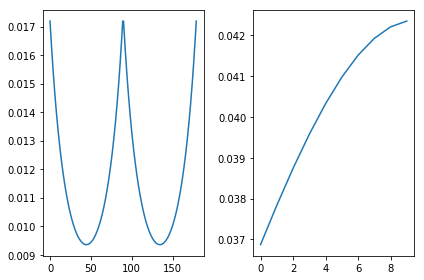

In [9]:
plt.subplot(1, 2, 1);plt.plot(dx_q[-1,:]); 
plt.subplot(1, 2, 2);plt.plot(dy_q[:,Ni//8]);
plt.tight_layout(); plt.show();

In [10]:
rp=np.tan(0.5*(90-lat0_bp)*PI_180)
dx_q,dy_q,da_q = bipolar_cap_metrics_quad_fast(5,Ni,Nj_ncap,lat0_bp,lon_bp,rp,Re=1)    
print("quad=5 %errors in (area,lat arc,lon arc)", metrics_error(dx_q, dy_q, da_q, lat1=lat0_bp,Re=1))

quad=5 %errors in (area,lat arc,lon arc) (2.2860285063589726e-09, 2.1203697876423447e-14, -5.654319433712917e-14)


In [13]:
rp=np.tan(0.5*(90-lat0_bp)*PI_180)
ii=0
area=[]
area_error=[]
nj=[]
for Nj_ in range(100,1200,100):
    dx_q,dy_q,da_q = bipolar_cap_metrics_quad_fast(4,Ni,Nj_,lat0_bp,lon_bp,rp,Re=1)    
    are,la,lo,ar = metrics_error(dx_q, dy_q, da_q, lat1=lat0_bp,Re=1,debug=True)
    area.append(ar)    
    area_error.append(are)    
    nj.append(Nj_)
    print(nj[ii],area_error[ii] )
    ii = ii+1

100 3.772019574330273e-12
200 -5.3230318188800636e-11
300 5.381062889254375e-11
400 -3.351294314116512e-11
500 8.11116097277314e-12
600 -1.2082332629524348e-10
700 2.8791324233437015e-11
800 -1.1744697310982895e-10
900 5.592084963342782e-11
1000 -2.690531444627188e-12
1100 -2.0867445351417337e-10
